In [1]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

# datasets
from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset
from my_code.datasets.surreal_cached_test_dataset import SurrealTestDataset

# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

In [2]:
import yaml
import torch

exp_dir = '/home/s94zalek/shape_matching/my_code/experiments/test_32'

with open(exp_dir + '/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

dataset_base_folder = '/home/s94zalek/shape_matching/data/SURREAL_full/full_datasets'
test_dataset = SurrealTestDataset(f'{dataset_base_folder}/{config["dataset_name"]}/test')

In [3]:
import torch

model = DiagConditionedUnet(config["model_params"]).to('cuda')

# load checkpoint_29.pt
model.load_state_dict(torch.load(exp_dir + '/checkpoint_29.pt'))
model = model.to('cuda')

In [4]:
from tqdm import tqdm
from diffusers import DDPMScheduler
import my_code.diffusion_training.sample_model as sample_model

batch_size = len(test_dataset)

# subset_indices = list(range(len(test_dataset)))
subset_indices = list(range(100))
test_subset = torch.utils.data.Subset(test_dataset, subset_indices)


test_loader = torch.utils.data.DataLoader(
    test_subset,
    batch_size=batch_size, shuffle=False
    )
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True)


x_gt = torch.stack(
    [test_dataset[i]['second']['C_gt_xy'] for i in subset_indices]
)

# x_sampled = sample_model.sample(model, test_loader, noise_scheduler)
x_sampled = torch.load(exp_dir + '/x_sampled_29.pt')[subset_indices]

In [ ]:
import torchvision
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax_0 = ax[0].imshow(torchvision.utils.make_grid(
    (x_sampled[:25].detach().cpu() + 1) / 2, nrow=5, value_range=(-1, 1)#, scale_each=True
    )[0], cmap='Greys')
# plt.colorbar(ax_plot, ax=ax)

ax[0].set_title('Generated samples')

ax_1 = ax[1].imshow(torchvision.utils.make_grid(
    x_gt[:25].detach().cpu().abs(), nrow=5, value_range=(-1, 1)#, scale_each=True
    )[0], cmap='Greys')

ax[1].set_title('Ground truth samples')


# ax.axis('off')

plt.show()

In [5]:
# unnormalize the samples
# and assign gt signs

fmap_sampled = []

for i in range(len(x_sampled)):

    fmap_i = x_sampled[i].cpu()
    fmap_i = (fmap_i + 1) / 2
    
    fmap_i = fmap_i * torch.sign(x_gt[i])

    # make random signs
    # signs = torch.randint(0, 2, (fmap_i.shape[0], 1, 1)).float() * 2 - 1
    # fmap_i = fmap_i * signs
    
    fmap_sampled.append(fmap_i)
    
fmap_sampled = torch.stack(fmap_sampled)

In [22]:
import importlib
importlib.reload(evaluate_samples)

<module 'my_code.diffusion_training.evaluate_samples' from '/home/s94zalek/shape_matching/my_code/diffusion_training/evaluate_samples.py'>

In [36]:
import my_code.diffusion_training.evaluate_samples as evaluate_samples

# metrics = evaluate_samples.calculate_metrics(
#     fmap_sampled,
#     test_subset
# )

print(f"AUC mean: {metrics['auc'].mean(dim=0):.2f}")
print()
print(f'GeoErr mean: {metrics["geo_err_est"].mean() * 100:.1f}')
print()
print(f"GeoErr ratio mean: {metrics['geo_err_ratio'].mean():.2f}")
print(f"GeoErr ratio median: {metrics['geo_err_ratio'].median():.2f}")
print(f'GeoErr ratio max: {metrics["geo_err_ratio"].max():.2f}', f'min: {metrics["geo_err_ratio"].min():.2f}')
print()
print(f"MSE mean: {metrics['mse_abs'].mean():.2f}")
print(f"MSE median: {metrics['mse_abs'].median():.2f}")
print(f'MSE max: {metrics["mse_abs"].max():.2f}', f'min: {metrics["mse_abs"].min():.2f}')


AUC mean: 0.65

GeoErr mean: 3.5

GeoErr ratio mean: 1.16
GeoErr ratio median: 1.13
GeoErr ratio max: 1.61 min: 0.89

MSE mean: 3.02
MSE median: 2.60
MSE max: 7.96 min: 0.83


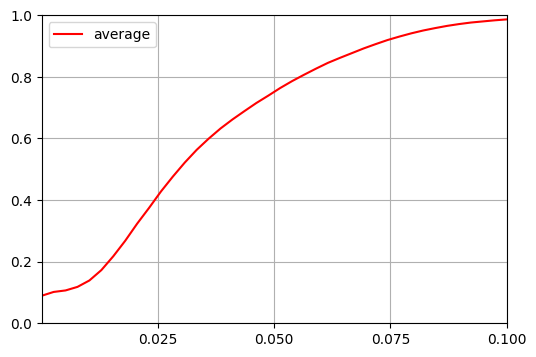

In [39]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

thresholds = np.linspace(0., 0.1, 40)
ax.plot(thresholds, torch.mean(metrics['pcks'], axis=0), 'r-', label=f'average')

ax.set_xlim(0., 0.1)
ax.set_ylim(0, 1)

ax.set_xscale('linear')
ax.set_xticks([0.025, 0.05, 0.075, 0.1])

ax.grid()
ax.legend()

fig.show()

In [107]:
# sort the indices according to the geodesic error, highest first
sort_idx_mse_abs = torch.argsort(metrics['mse_abs'], descending=True)
sort_idx_geo_err_est = torch.argsort(metrics['geo_err_est'] / metrics['geo_err_gt'], descending=True)

batch_highest_error = test_subset[sort_idx_mse_abs[0]]

# print all metrics for the highest error sample

for i in sort_idx_mse_abs[:5]:
    print(f"{i}) Geo err: {metrics['geo_err_est'][i] / metrics['geo_err_gt'][i]:.2f}, mse_abs: {metrics['mse_abs'][i]:.2f}")
    
print()
    
for i in sort_idx_geo_err_est[:5]:
    print(f"{i}) Geo err: {metrics['geo_err_est'][i] / metrics['geo_err_gt'][i]:.2f}, mse_abs: {metrics['mse_abs'][i]:.2f}")
    

714) Geo err: 1.89, mse_abs: 12.41
361) Geo err: 1.27, mse_abs: 10.32
797) Geo err: 1.21, mse_abs: 10.24
791) Geo err: 1.17, mse_abs: 10.16
278) Geo err: 1.22, mse_abs: 9.83

298) Geo err: 2.04, mse_abs: 5.93
714) Geo err: 1.89, mse_abs: 12.41
839) Geo err: 1.83, mse_abs: 5.91
400) Geo err: 1.74, mse_abs: 6.25
121) Geo err: 1.74, mse_abs: 4.58


idx_mse MSE: 0.69, GeoErr: 1.06
idx_geo MSE: 3.24, GeoErr: 0.88


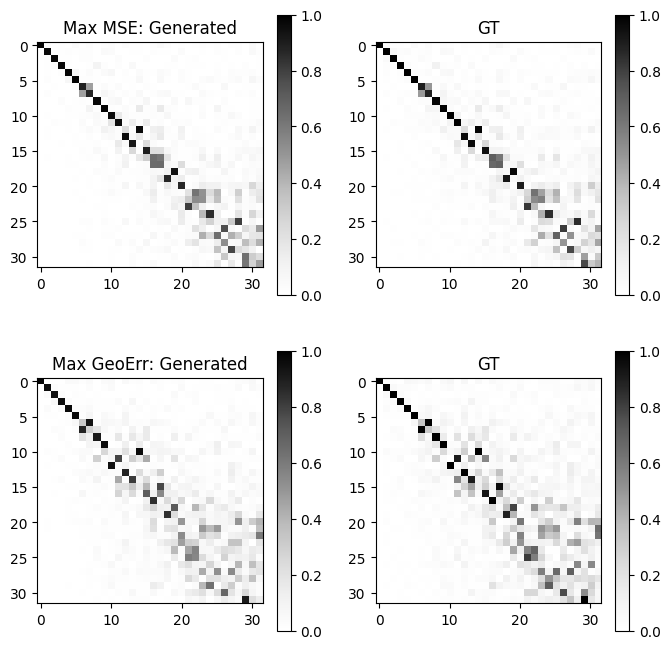

In [111]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

idx_mse = -1
idx_geo = -1

print(f"idx_mse MSE: {metrics['mse_abs'][sort_idx_mse_abs[idx_mse]]:.2f}, GeoErr: {metrics['geo_err_ratio'][sort_idx_mse_abs[idx_mse]]:.2f}")
print(f"idx_geo MSE: {metrics['mse_abs'][sort_idx_geo_err_est[idx_geo]]:.2f}, GeoErr: {metrics['geo_err_ratio'][sort_idx_geo_err_est[idx_geo]]:.2f}")

ax_0 = ax[0][0].imshow(fmap_sampled[sort_idx_mse_abs[idx_mse]][0].abs(), cmap='Greys', vmin=0, vmax=1)
plt.colorbar(ax_0, ax=ax[0][0])
ax[0][0].set_title('Max MSE: Generated')

ax_1 = ax[0][1].imshow(x_gt[sort_idx_mse_abs[idx_mse]][0].abs(), cmap='Greys', vmin=0, vmax=1)
plt.colorbar(ax_1, ax=ax[0][1])
ax[0][1].set_title('GT')

ax_0 = ax[1][0].imshow(fmap_sampled[sort_idx_geo_err_est[idx_geo]][0].abs(), cmap='Greys', vmin=0, vmax=1)
plt.colorbar(ax_0, ax=ax[1][0])
ax[1][0].set_title('Max GeoErr: Generated')

ax_1 = ax[1][1].imshow(x_gt[sort_idx_geo_err_est[idx_geo]][0].abs(), cmap='Greys', vmin=0, vmax=1)
plt.colorbar(ax_1, ax=ax[1][1])
ax[1][1].set_title('GT')

plt.show()


In [ ]:
import trimesh
import numpy as np

scene = trimesh.Scene()

cmap = trimesh.visual.color.interpolate(batch_highest_error['first']['verts'][:, 1], 'jet')

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=batch_highest_error['first']['verts'].cpu().numpy(), faces=batch_highest_error['first']['faces'].cpu().numpy())
mesh1.visual.vertex_colors = cmap[:len(mesh1.vertices)].clip(0, 255)
scene.add_geometry(mesh1)

mesh2 = trimesh.Trimesh(vertices=batch_highest_error['second']['verts'].cpu().numpy() + np.array([1, 0, 0]), faces=batch_highest_error['second']['faces'].cpu().numpy())
cmap2 = cmap[
             metrics['p2p_est'][sorted_indices[0]].cpu().numpy().astype(int)
             ][:len(mesh2.vertices)]
mesh2.visual.vertex_colors = cmap2
scene.add_geometry(mesh2)

scene.show()


In [ ]:
# get indices with nonzero elements of cmap/255 - cmap[p2p]/255

idx_nonzero = np.where(np.sum(difference, axis=1) > 0)[0]

for i in idx_nonzero:
    print(f'Vertex {i} has a difference of {difference[i]}: {cmap[i] / 255} vs {cmap[p2p][i] / 255}')